## Painting Classifier by Style

### Imports

In [23]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import seaborn as sns
import os
import matplotlib.pyplot as plt
import numpy as np

### Loading in the data

In [13]:
df = pd.read_csv("all_data_info.csv")
df

artist    date               genre  pixelsx  pixelsy  \
0                Barnett Newman  1955.0            abstract  15530.0   6911.0   
1                Barnett Newman  1950.0            abstract  14559.0   6866.0   
2                   kiri nichol  2013.0                 NaN   9003.0   9004.0   
3                   kiri nichol  2013.0                 NaN   9003.0   9004.0   
4                   kiri nichol  2013.0                 NaN   9003.0   9004.0   
...                         ...     ...                 ...      ...      ...   
103245          Jackson Pollock  1948.0            abstract    682.0    220.0   
103246         Bernardo Strozzi     NaN  religious painting    329.0    456.0   
103247               Josef Sima     NaN           landscape    293.0    512.0   
103248           Brett Whiteley  1982.0              marina    293.0    512.0   
103249  Amadeo de Souza-Cardoso    1913           landscape    293.0    512.0   

        size_bytes   source                 style                     title  \
0        9201912.0  wikiart  Color Field Painting                     Uriel   
1        8867532.0  wikiart  Color Field Painting     Vir Heroicus Sublimis   
2        1756681.0      NaN         Neoplasticism                       NaN   
3        1942046.0      NaN         Neoplasticism                       NaN   
4        1526212.0      NaN         Neoplasticism                       NaN   
...            ...      ...                   ...                       ...   
103245     96405.0  wikiart       Action painting    Number 13A (Arabesque)   
103246    127594.0  wikiart               Baroque     St. Francis of Assisi   
103247    102519.0  wikiart            Surrealism  Maisons à la campagne II   
103248    167423.0  wikiart                   NaN           Thebe's Revenge   
103249     77577.0  wikiart                Cubism            House Manhufe    

          artist_group  in_train new_filename  
0           train_only      True   102257.jpg  
1           train_only      True    75232.jpg  
2            test_only     False    32145.jpg  
3            test_only     False    20304.jpg  
4            test_only     False      836.jpg  
...                ...       ...          ...  
103245  train_and_test      True    25525.jpg  
103246      train_only      True    47038.jpg  
103247  train_and_test     False     7680.jpg  
103248  train_and_test      True     9021.jpg  
103249      train_only      True    36564.jpg  

[103250 rows x 12 columns]

### Visualizing some of the art 

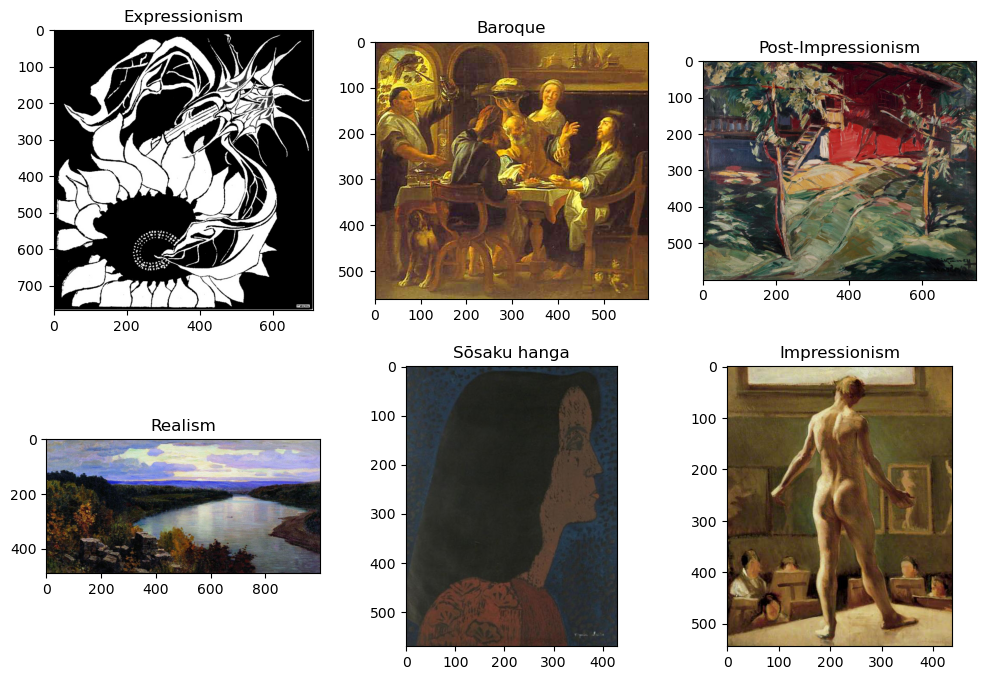

In [14]:
train_1_folder = "train_1"

# create a figure with 2 rows and 3 columns of subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

# loop through the first 6 images
for i in range(6):
    # get the image path and read the image
    img_name = os.listdir(train_1_folder)[i]
    img_path = os.path.join(train_1_folder, img_name)
    img = plt.imread(img_path)
    
    # find the corresponding row in the DataFrame
    row = df[df["new_filename"] == img_name].iloc[0]
    
    # get the artist, title, and style information
    artist = row["artist"]
    title = row["title"]
    style = row["style"]
    
    # plot the image in the appropriate subplot
    row_index, col_index = divmod(i, 3)
    axs[row_index, col_index].imshow(img)
    axs[row_index, col_index].set_title(style)

# show the figure
plt.show()

### Preprocessing

It is evident we have a ton of data to work with. Let's take a deeper look into the Style column since we will be working with it extensively.

In [15]:
df["style"].value_counts()

Impressionism               10643
Realism                     10523
Romanticism                  9285
Expressionism                7013
Post-Impressionism           5778
                            ...  
Spectralism                     5
Kinetic Art                     3
Ilkhanid                        2
Renaissance                     1
Environmental (Land) Art        1
Name: style, Length: 136, dtype: int64

There is a huge imbalance in the data here. We have 5 instances of artworks that fall under the spectralism category and have more than 10,000 impressionism style paintings. We would be naive to train our model on the dataset as is. We need to filter out styles that do not have enough samples and also those that have too many. Here, the choice for the threshold is really arbitrary and we decided to work with art styles with 2,000 samples. This means that styles like realism with several thousands of paintings need to be cut down to as close to 2,000 as possible.

Text(0.5, 0, 'Number of paintings')

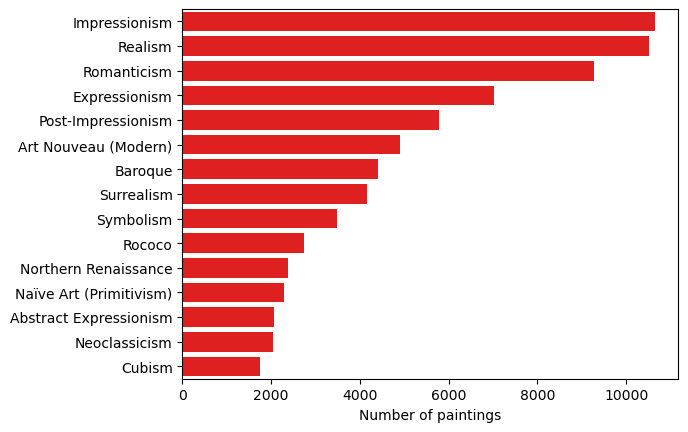

In [16]:
df["style"].value_counts()[:15]

sns.barplot(x=df["style"].value_counts()[:15].values, y=df["style"].value_counts()[:15].index,
            color="r")
plt.xlabel("Number of paintings")

Looking at the 15 most populated styles in our dataset, we see that Neoclassicism is just above our threshold with 2,038 samples. So, the next step is to cut down all samples above our threshold to meet our requirements for an unbiased dataset. To do this we will create a function to loop over the overpopulated styles, find the difference between them and the count for our Neoclassicism style, and reduce it to match our minimum limit.

In [17]:
overpop_styles = df["style"].value_counts()[:14].index.tolist()
overpop_styles

['Impressionism',
 'Realism',
 'Romanticism',
 'Expressionism',
 'Post-Impressionism',
 'Art Nouveau (Modern)',
 'Baroque',
 'Surrealism',
 'Symbolism',
 'Rococo',
 'Northern Renaissance',
 'Naïve Art (Primitivism)',
 'Abstract Expressionism',
 'Neoclassicism']

In [18]:
def style_balancer(style_arr, df):
    """
    Reduce the number of samples for each overpopulated style in the given DataFrame to match the count of the
    least represented style, and return a new DataFrame with the reduced number of samples for each style.

    Parameters:
        style_arr (list of str): A list of style names to balance.
        df (pandas.DataFrame): The DataFrame containing the samples to balance.

    Returns:
        pandas.DataFrame: A new DataFrame with the reduced number of samples for each style.

    Raises:
        None

    """

    # Get the minimum number of samples for any style in the DataFrame
    min_val = df["style"].value_counts()[13] # assuming "Neoclassicism" is at index 13

    # Initialize an empty DataFrame variable to hold the balanced samples for all styles
    empty_df_var = None

    # Loop through each style in the style_arr list
    for _style in style_arr:
        # Create a boolean mask to select only the samples with the current style
        style_mask = df["style"] == _style

        # Create a new DataFrame with only the samples with the current style
        style_df = df[style_mask]

        # Calculate the total number of samples for the current style
        tot = len(style_df.index)

        # Calculate the number of samples to remove to match the minimum count
        rmv = tot - min_val

        # Remove the excess samples from the current style DataFrame
        style_df.drop(style_df.index[range(rmv)], inplace=True)

        # Concatenate the current style DataFrame to the empty_df_var DataFrame to add it to the new DataFrame
        fin_df = pd.concat([empty_df_var, style_df], ignore_index=True)

        # Update the empty_df_var DataFrame with the new DataFrame containing the current style
        empty_df_var = fin_df

    # Return the final DataFrame containing the balanced samples for all styles
    return fin_df


df = style_balancer(overpop_styles, df)
df["style"].value_counts()


Impressionism              2038
Realism                    2038
Romanticism                2038
Expressionism              2038
Post-Impressionism         2038
Art Nouveau (Modern)       2038
Baroque                    2038
Surrealism                 2038
Symbolism                  2038
Rococo                     2038
Northern Renaissance       2038
Naïve Art (Primitivism)    2038
Abstract Expressionism     2038
Neoclassicism              2038
Name: style, dtype: int64

## !!!FIX!!! WHAT IF FILE ISN'T IN TRAIN FOLDER

In [21]:
df["in_train"].value_counts()
df

artist    date                 genre  pixelsx  \
0                  Berthe Morisot    1875                marina    787.0   
1          James McNeill Whistler    1884              portrait    509.0   
2          William James Glackens    1912        genre painting    800.0   
3                   Alfred Sisley    1874             landscape    800.0   
4                 Joaquín Sorolla     NaN             cityscape    598.0   
...                           ...     ...                   ...      ...   
28527  William-Adolphe Bouguereau     NaN  allegorical painting    300.0   
28528            Vieira Portuense  1801.0      history painting    460.0   
28529      Pierre-Narcisse Guerin     NaN         self-portrait    338.0   
28530    Marie-Guillemine Benoist  1810.0              portrait    341.0   
28531       Vladimir Borovikovsky    1815              portrait    350.0   

       pixelsy  size_bytes   source          style  \
0        608.0    104935.0  wikiart  Impressionism   
1        940.0     57847.0  wikiart  Impressionism   
2        598.0    189380.0  wikiart  Impressionism   
3        598.0    156856.0  wikiart  Impressionism   
4        800.0    147766.0  wikiart  Impressionism   
...        ...         ...      ...            ...   
28527    520.0     25180.0  wikiart  Neoclassicism   
28528    331.0     26080.0  wikiart  Neoclassicism   
28529    450.0     31277.0  wikiart  Neoclassicism   
28530    444.0     53661.0  wikiart  Neoclassicism   
28531    432.0     42650.0  wikiart  Neoclassicism   

                                           title    artist_group  in_train  \
0                                 Aboard a Yacht  train_and_test     False   
1                               The Chelsea Girl  train_and_test     False   
2                       Sledding in Central Park  train_and_test      True   
3                           Snow at Louveciennes  train_and_test      True   
4                           Church Roncal stairs  train_and_test      True   
...                                          ...             ...       ...   
28527                                      Night  train_and_test      True   
28528  Dona Filipa de Vilhena knighting her sons      train_only      True   
28529                              Self Portrait  train_and_test      True   
28530      Portrait of Napoleona Elisa Baciocchi      train_only      True   
28531                              Peter A Kikin  train_and_test      True   

      new_filename  
0        69077.jpg  
1        56286.jpg  
2        28617.jpg  
3        46313.jpg  
4        97489.jpg  
...            ...  
28527    57857.jpg  
28528    80972.jpg  
28529    37644.jpg  
28530    22623.jpg  
28531    38877.jpg  

[28532 rows x 12 columns]

## SHUFFLE DATA

In [26]:
#our data is currently organized by style, we want to shuffle our data so we don't have bias data
#takes a set data frame and shuffles it by style 
df = df.iloc[np.random.permutation(len(df))]
df

artist    date  \
24842                                      Joan Mitchell    1981   
3756                                         Anders Zorn    1891   
17721                               Mstislav Dobuzhinsky     NaN   
21888  St. John the Baptist and the Donor, Heinrich V...    1438   
27341                         Giovanni Battista Piranesi     NaN   
...                                                  ...     ...   
28375                                        Carlo Carra  1935.0   
6313                                         John Bratby     NaN   
7832                                          Alice Neel    1964   
19308                         Maurice Quentin de La Tour     NaN   
7712                                         Bela Czobel  1937.0   

                    genre  pixelsx  pixelsy  size_bytes   source  \
24842            abstract   1200.0    463.0    243556.0  wikiart   
3756       genre painting    380.0    516.0     78655.0  wikiart   
17721           cityscape    509.0    763.0    203499.0  wikiart   
21888  religious painting    532.0   1250.0    133044.0  wikiart   
27341           cityscape   1138.0   1500.0    554735.0  wikiart   
...                   ...      ...      ...         ...      ...   
28375      genre painting    462.0    600.0     98767.0  wikiart   
6313      flower painting    439.0    685.0     58527.0  wikiart   
7832             portrait    340.0    512.0     28403.0  wikiart   
19308            portrait    687.0    888.0     96154.0  wikiart   
7712             portrait    381.0    475.0     74765.0  wikiart   

                        style  \
24842  Abstract Expressionism   
3756                  Realism   
17721               Symbolism   
21888    Northern Renaissance   
27341           Neoclassicism   
...                       ...   
28375           Neoclassicism   
6313            Expressionism   
7832            Expressionism   
19308                  Rococo   
7712            Expressionism   

                                                   title    artist_group  \
24842                                       Edrita Fried  train_and_test   
3756                                              Margit  train_and_test   
17721                         Perugia. Lion and gryphon.  train_and_test   
21888                                    Werl Altarpiece       test_only   
27341  Plan and elevation rear of the Temple of the S...  train_and_test   
...                                                  ...             ...   
28375                                         Pescatori   train_and_test   
6313                                            Daffodil  train_and_test   
7832                                       Sherry Speeth      train_only   
19308  Francois Dachery, childhood friend of Maurice ...  train_and_test   
7712                                             Madonna       test_only   

       in_train new_filename  
24842      True    34437.jpg  
3756       True    11695.jpg  
17721      True    24537.jpg  
21888     False    85758.jpg  
27341      True     5846.jpg  
...         ...          ...  
28375      True    53736.jpg  
6313       True    84243.jpg  
7832       True    34746.jpg  
19308      True    46661.jpg  
7712      False    93872.jpg  

[28532 rows x 12 columns]

## !!!FIX!!! STANDARDIZE IMAGES

In [ ]:
def stand_image(img, df):
    """ 
    Takes all of the images and converts them all into the same size. 
    This is so our ML algorithm won't take image size into account for groups 
    
    Parameters:

    image or image ary:
    dataframe 
    
    Returns: 
    Pandas data frame that returns images that are all the same size
    """
    
    
    